<a href="https://colab.research.google.com/github/anuva05/PracticalDeepLearningCourse/blob/master/Lesson5_SGD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
from fastai.basics import *

## MNIST SGD

Get the 'pickled' MNIST dataset from http://deeplearning.net/data/mnist/mnist.pkl.gz. We're going to treat it as a standard flat dataset with fully connected layers, rather than using a CNN.

In [0]:
path = Config.data_path()
folder='mnist'
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)


#Now, download the dataset and upload it to the Colab runtime environment
#Then, run the following 

!mv mnist.pkl.gz {dest}

In [3]:
path = dest 
path.ls()

[PosixPath('/root/.fastai/data/mnist/mnist.pkl.gz')]

In [0]:
#Open the pickled dataset
with gzip.open(path/'mnist.pkl.gz', 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

(50000, 784)

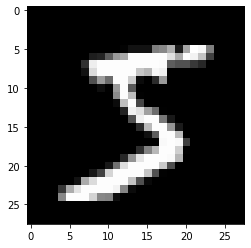

In [5]:
plt.imshow(x_train[0].reshape((28,28)), cmap="gray")
x_train.shape

In [6]:
x_train,y_train,x_valid,y_valid = map(torch.tensor, (x_train,y_train,x_valid,y_valid))
n,c = x_train.shape
x_train.shape, y_train.min(), y_train.max()

(torch.Size([50000, 784]), tensor(0), tensor(9))

In lesson2-sgd we implemented:

```python
x = torch.ones(n,2) 
def mse(y_hat, y): return ((y_hat-y)**2).mean()
y_hat = x@a
```

In this lesson, we use PyTorch's functions to do it for us, and also to handle mini-batches.

In [0]:
bs=64 #batch size
train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)
#The next line creates an iterator that gives you the next minibatch when asked for 'next'
data = DataBunch.create(train_ds, valid_ds, bs=bs)

In [8]:
#To get the next batch of size bs 
x,y = next(iter(data.train_dl))
x.shape,y.shape

(torch.Size([64, 784]), torch.Size([64]))

In [0]:
#Create a nn.Module and overwrite the constructor to
#create a linear layer that will compute x@a + b for input matrix x.
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10, bias=True)

    def forward(self, xb): return self.lin(xb)

In [0]:
#Explicitly specify using GPUs, copy data
model = Mnist_Logistic().cuda()

In [11]:
model

Mnist_Logistic(
  (lin): Linear(in_features=784, out_features=10, bias=True)
)

In [12]:
model.lin

Linear(in_features=784, out_features=10, bias=True)

In [13]:
model(x).shape

torch.Size([64, 10])

In [14]:
#The parameters contains weights and biases. the 10x784 entity is the matrix to be multiplied
# and the other quantity has 10 activations which we want to add our biases to
[p.shape for p in model.parameters()]

[torch.Size([10, 784]), torch.Size([10])]

In [0]:
lr=2e-2

The loss for wrongly recognizing a digit cannot be quantified using MSE. Identifying a '3' as a '4' is just as wrong as identifying it as a '5'. Hence, we will use Cross Entropy Loss as the loss function here. 

In [0]:
#nn.CrossEntropyloss includes a SoftMax function so that predictions are in range [0,1] and
#sum upto 1
loss_func = nn.CrossEntropyLoss() 

Next, we write the weight update function. We also implement weight decay in it, which prevents the weights from growing too large, which in turn helps our model generalize better. 

In [0]:
def update(x,y,lr):
    wd = 1e-5
    y_hat = model(x)
    # weight decay
    w2 = 0.
    for p in model.parameters(): w2 += (p**2).sum()
    #Implement weight decay:add to regular loss
    loss = loss_func(y_hat, y) + w2*wd
    loss.backward()
    with torch.no_grad():
        for p in model.parameters():
            p.sub_(lr * p.grad)
            p.grad.zero_()
    
    #calling .item() on a tensor converts it to scalar Python number 
    return loss.item()

In [0]:
losses = [update(x,y,lr) for x,y in data.train_dl]

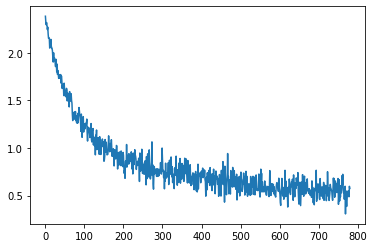

In [20]:
plt.plot(losses);

Loss is going down! That's a good sign. 

Another point to note- when taking gradient of loss wrt weights, since we added the weight decay term, we now realize that the gradient of that weight decay term is important. if it were a single weight, that gradient = 2 times wd times w wrt w.  THus, weight decay essentially subtracts a constant times the weight from the weight in each update step.

In [0]:
#If we add another linear layer..
class Mnist_NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(784, 50, bias=True)
        self.lin2 = nn.Linear(50, 10, bias=True)

    def forward(self, xb):
        x = self.lin1(xb)
        x = F.relu(x)
        return self.lin2(x)

In [0]:
model = Mnist_NN().cuda()

In [0]:
losses = [update(x,y,lr) for x,y in data.train_dl]

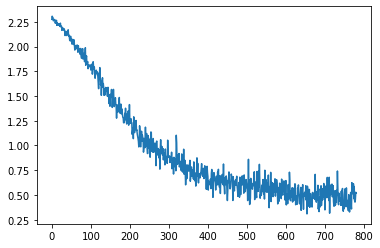

In [24]:
plt.plot(losses);

In [0]:
model = Mnist_NN().cuda()

Let's see how we can do it with the inbuilt optimizer functions instead. Using SGD to optimize would look like the snippet below. the ```opt.step()``` replaces the explicit update computation we did in the previous ```update()``` function. 

In [0]:
def update(x,y,lr):
    opt = optim.SGD(model.parameters(), lr)
    y_hat = model(x)
    loss = loss_func(y_hat, y)
    loss.backward()
    opt.step()
    opt.zero_grad()
    return loss.item()

In [0]:
losses = [update(x,y,1e-3) for x,y in data.train_dl]

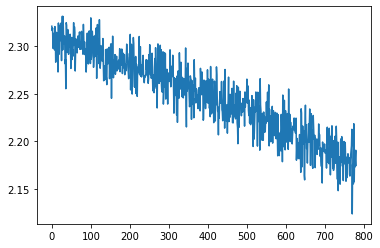

In [28]:
plt.plot(losses);

We can also use the Adam optimizer, like so: 

In [0]:
def update(x,y,lr):
    opt = optim.Adam(model.parameters(), lr)
    y_hat = model(x)
    loss = loss_func(y_hat, y)
    loss.backward()
    opt.step()
    opt.zero_grad()
    return loss.item()

In [0]:
losses = [update(x,y,1e-3) for x,y in data.train_dl]

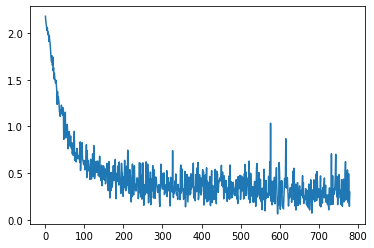

In [31]:
plt.plot(losses);

We could also add weight decay, with a conservative parameter setting of 0.01: 

In [0]:
def update(x,y,lr):
    opt = optim.Adam(model.parameters(), lr, weight_decay=0.01)
    y_hat = model(x)
    loss = loss_func(y_hat, y)
    loss.backward()
    opt.step()
    opt.zero_grad()
    return loss.item()

In [0]:
losses = [update(x,y,1e-3) for x,y in data.train_dl]

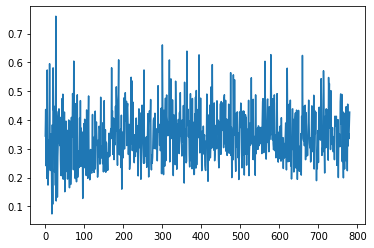

In [34]:
plt.plot(losses);

In the case of the last optimizer we used, the loss isn't looking so good. It looks like it is diverging.
If this happens, the weights have gotten too big and it is hard to reduce them again, so we should start the training all over again.

If the SGD is not converging quick enough, we can add momentum to it, which basically changest the learning rate so that the convergence is sped up. Usually, momentum is set to 0.9.

 RMS Prop is popular and is exponentially weighted average of the gradient squared. If the gradient is small and continues to be small, this number will be small (and the jump is bigger) . If the gradient is volatile, it will be large(and the jump is smaller).  Adam Optimizer uses momentum and RMS prop. 
 These methods are thus called methods that use a *dynamic learning rate*. 

In [0]:
#Now, we use fast.ai to do all the above for us, using 'Learner'
learn = Learner(data, Mnist_NN(), loss_func=loss_func, metrics=accuracy)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


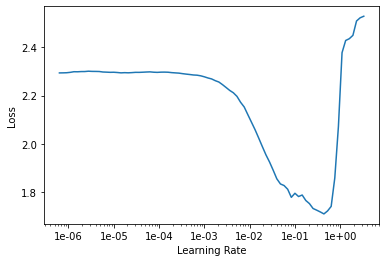

In [36]:
learn.lr_find()
learn.recorder.plot()

In [37]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.136847,0.126635,0.961700,00:03


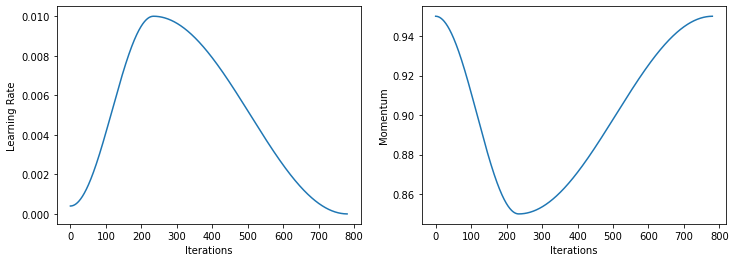

In [38]:
learn.recorder.plot_lr(show_moms=True)


Plots: On the left side is the learning rate, on the right side, we have momentum.
When learning rate is small, momentum is large and vice versa. This is because, when learning rate is small and we're going in the same direction, we might as well go faster.
Both these plots are for changes during one cycle and having a dynamic learning rate such as this can make a huge difference to speedup. 
Note how learning rate increases at first (when we don't know how close we are to the answer) and then decreases (as we get closer to the answer). 

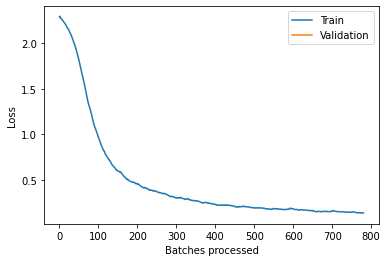

In [39]:
learn.recorder.plot_losses()